<img src="images/ipsa_logo.png" width="100" align="right">

# Ma422- 2024/2025

# <font color='black'> Introduction to Machine Learning</font>

---


1. [Set-Up](#Set-Up)
2. [Multi-class Classification](#NN)
 * [Visualizing the data](#MR)
 * [Vectorizing logistic regression](#MR)
 * [One-vs-all classication](#MR)

---

The objective of this lab session is to deal with the multi-class classification.


## <font color='black'>Set-Up</font>

---

First we will import the packages that we will need throughout the notebook.

In [1]:
import os
import numpy as np
from matplotlib import pyplot
from scipy import optimize
from scipy.io import loadmat
import utils

# tells matplotlib to embed plots within the notebook
%matplotlib inline

## <font color='black'>Multi-class Classification</font>

---

You will use logistic regression to recognize handwritten digits (from 0 to 9). Automated handwritten digit recognition is widely used today - from recognizing zip codes (postal codes) on mail envelopes to recognizing amounts written on bank checks. This exercise will show you how the methods you've learned can be used for this classication task. You will implement the logistic regression and apply it to one-vs-all classification.

###  Visualizing the data

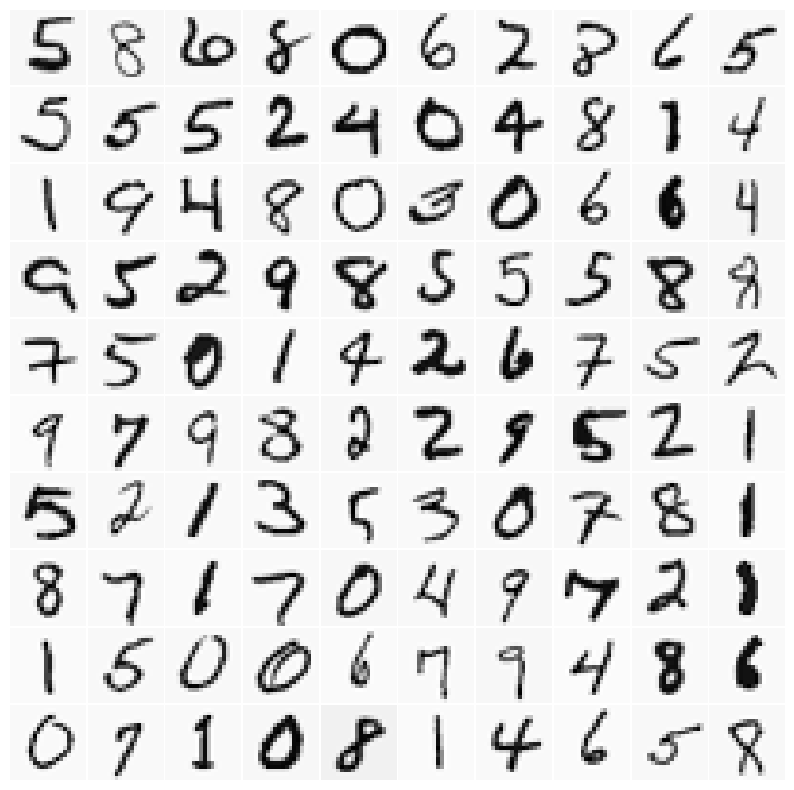

In [2]:
#  training data stored in arrays X, y
data = loadmat(os.path.join('ex3data1.mat'))
X, y = data['X'], data['y'].ravel()

# set the zero digit to 0, rather than its mapped 10 in this dataset
y[y == 10] = 0

# get number of examples in dataset
m = y.size

# randomly permute examples, to be used for visualizing one
# picture at a time
indices = np.random.permutation(m)

# Randomly select 100 data points to display
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

utils.displayData(sel)

###  Vectorizing logistic regression
You will be using multiple one-vs-all logistic regression models to build a multi-class classifier. Since there are 10 classes, you will need to train 10 separate logistic regression classifiers. To make this training efficient, it is important to ensure that your code is well vectorized. In this section, you will implement a vectorized version of logistic regression that does not employ any `for` loops.

#### Vectorizing the cost function
We will begin by writing a vectorized version of the cost function. Recall that in (unregularized) logistic regression, the cost function is

$$
J(\boldsymbol{\theta}) = -\frac{1}{N}\sum_{i=1}^{N}y^{(i)} \ln\left(h_{\theta}(x^{(i)})\right)+ (1-y^{(i)})\ln\left(1-h_{\theta}(x^{(i)})\right)
$$

where

$$
h_{\theta}(x^{(i)})=\frac{1}{1+e^{-\boldsymbol{\theta}^T \boldsymbol{x}^{(i)}}}
$$


It turns out that we can compute this quickly for all our examples by using matrix multiplication. Let us define $\boldsymbol{X}$ and $\boldsymbol{\theta}$ as

$$
\boldsymbol{X}\boldsymbol{\theta} = \begin{bmatrix}
(\boldsymbol{x}^{(1)})^T \boldsymbol{\theta}\\
\vdots \\
(\boldsymbol{x}^{(N)})^T \boldsymbol{\theta}
\end{bmatrix}
$$
This allows us to compute the products $(\boldsymbol{x}^{(i)})^T \boldsymbol{\theta}$ for all our examples $i$ in one line of code. Your job is to write the unregularized cost function `lrCostFunction`. Your implementation should use the strategy we presented above to calculate . You should also use a vectorized approach for the rest of the cost function. A fully vectorized version of `lrCostFunction` should not contain any loops.

First of all; as we have seen in class the sigmoid function can take values in the range $[0,1]$. So large positive values of X will lead to the sigmoid close to 1, while for large negative values, the sigmoid should be close to 0. The sigmoid function is defined as:

$$
g(z) = \cfrac{1}{1 + e^{-z}}
$$

Implement this function in the cell below so it can be called by the rest of the exercise.

In [3]:
#EDIT THIS CELL
def sigmoid(z):
    z = np.array(z)

    # You need to return the following variables correctly
    g = np.zeros(z.shape)

    # ==================== YOUR CODE HERE =========================

    g = 1 / (1 + np.exp(-z))

    # =============================================================
    return g

The following cell evaluates the sigmoid function at `z=0`. You should get a value of 0.5. You can also try different values for `z` to experiment with the sigmoid function.

In [4]:
# Test the implementation of sigmoid function here
z = 0
g = sigmoid(z)

print('g(', z, ') = ', g)

g( 0 ) =  0.5


#### Vectorizing the gradient
Recall that the gradient of the (unregularized) logistic regression cost is a vector defined as

$$ \nabla J(\boldsymbol{\theta}) = \frac{\delta J(\boldsymbol{\theta})}{\delta \boldsymbol{\theta}} =  \frac{1}{N}\sum_{i=1}^{N} \left(\frac{1}{1+e^{-\boldsymbol{\theta}^T \boldsymbol{x}^{(i)}}}-y^{(i)}\right)\boldsymbol{x}^{(i)}, $$

To vectorize this operation over the dataset, we start by writing out all the partial derivatives explicitly for all $\boldsymbol{\theta}_j$

$$
 \begin{bmatrix}
 \frac{\delta J(\boldsymbol{\theta})}{\delta \boldsymbol{\theta}_0}\\
\vdots \\
 \frac{\delta J(\boldsymbol{\theta})}{\delta \boldsymbol{\theta}_M}
\end{bmatrix} = \frac{1}{N} \begin{bmatrix}
 \sum_{i=1}^{N} \left(\frac{1}{1+e^{-\boldsymbol{\theta}^T \boldsymbol{x}^{(i)}}}-y^{(i)}\right)x^{(i)}_0\\
\vdots \\
 \sum_{i=1}^{N} \left(\frac{1}{1+e^{-\boldsymbol{\theta}^T \boldsymbol{x}^{(i)}}}-y^{(i)}\right)x^{(i)}_M
\end{bmatrix} = \frac{1}{N} \boldsymbol{X}^T \left(\frac{1}{1+e^{-\boldsymbol{\theta}^T \boldsymbol{x}^{(i)}}}-y^{(i)}\right)
$$
where

$$
\left(\frac{1}{1+e^{-\boldsymbol{\theta}^T \boldsymbol{x}^{(i)}}}-y^{(i)}\right) = \begin{bmatrix}
 \left(\frac{1}{1+e^{-\boldsymbol{\theta}^T \boldsymbol{x}^{(1)}}}-y^{(1)}\right)\\
\vdots \\
  \left(\frac{1}{1+e^{-\boldsymbol{\theta}^T \boldsymbol{x}^{(N)}}}-y^{(N)}\right)\\
\end{bmatrix}
$$
is a $N$ vector and $\boldsymbol{x}^{(i)}$ is $M+1$ vector.

The expression above allows us to compute all the partial derivatives without any loops. If you are comfortable with linear algebra, we encourage you to work through the matrix multiplications above to convince yourself that the vectorized version does the same computations. Once you are done, complete the function `lrCostFunction` by implementing the gradient.

In [9]:
def lrCostFunction(theta, X, y):
    """
    Compute cost and gradient for logistic regression without regularization.

    Parameters:
    - theta (array): Model parameters (shape: (n,))
    - X (array): Feature matrix (shape: (m, n))
    - y (array): Target labels (shape: (m,))

    Returns:
    - J (float): Computed cost
    - grad (array): Computed gradient (shape: (n,))
    """
    N = y.size  # Number of training examples

    # Compute hypothesis (sigmoid function)
    z = X @ theta  # Vectorized computation of z
    h = sigmoid(z)  # Sigmoid function

    # Compute cost function (logistic regression without regularization)
    J = (-y @ np.log(h) - (1 - y) @ np.log(1 - h)) / N

    # Compute gradient (vectorized)
    grad = (X.T @ (h - y)) / N


    return J, grad


Once you are done test your `lrCostFunction` by executing the next cell.

In [10]:
theta_t = np.zeros(4);
theta_t[:] = [-2, -1, 1, 2];
X_t = np.zeros((5,4));
X_t[:,0] = np.ones(5);
X_t[:,1:] = np.transpose(np.reshape(list(range(1,16)),(3,5))/10);
y_t = np.zeros(5)
y_t[:] =  [1, 0, 1, 0,1];
lambda_t = 3;
cost, grad = lrCostFunction(theta_t, X_t, y_t);

print('Cost: {:.3f}'.format(cost));
print('Expected cost: 0.735\n');
print('Gradients:\n'); print(grad);
print('Expected gradients:\n 0.14656137 0.05144159 0.12472227 0.19800296');

Cost: 0.735
Expected cost: 0.735

Gradients:

[0.14656137 0.05144159 0.12472227 0.19800296]
Expected gradients:
 0.14656137 0.05144159 0.12472227 0.19800296


#### Vectorizing regularized logistic regression
After you have implemented vectorization for logistic regression, you will now add regularization to the cost function. Recall that for regularized logistic regression, the cost function is defined as

$$ J(\boldsymbol{\theta}) = -\frac{1}{N}\sum_{i=1}^{N}y^{(i)} \ln\left(\frac{1}{1+e^{-\boldsymbol{\theta}^T \boldsymbol{x}^{(i)}}}\right)+ (1-y^{(i)})\ln\left(1-\frac{1}{1+e^{-\boldsymbol{\theta}^T \boldsymbol{x}^{(i)}}}\right)
+ \frac{\lambda}{2N}\sum_{j=1}^{M}|\theta_j|,
$$

Note that you should not be regularizing $\theta_0$ which is used for the bias term. Correspondingly, the partial derivative of regularized logistic regression cost for $\theta_j$ is defined as

$$ \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{N} \sum_{i=1}^N \left( h_\theta \left(x^{(i)}\right) - y^{(i)} \right) x_j^{(i)} \qquad \text{for } j =0 $$

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \left( \frac{1}{N} \sum_{i=1}^N \left( h_\theta \left(x^{(i)}\right) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{N}|\theta_j| \qquad \text{for } j \ge 1 $$

Modify now your code in `lrCostFunction` to account for regularization.
Once again, you should not put any loops into your code.

In [13]:
def lrCostFunction(theta, X, y, lambda_):
    """
    Compute cost and gradient for logistic regression with regularization.

    Parameters:
    - theta (array): Model parameters (shape: (n,))
    - X (array): Feature matrix (shape: (m, n))
    - y (array): Target labels (shape: (m,))
    - lambda_ (float): Regularization parameter

    Returns:
    - J (float): Computed cost
    - grad (array): Computed gradient (shape: (n,))
    """
    m = y.size  # Number of training examples

    n = len(theta)  # Number of features (including bias)

    # Compute hypothesis (sigmoid function)
    z = X @ theta
    h = sigmoid(z)

    # Compute cost function with regularization
    reg_term = (lambda_ / (2 * m)) * np.sum(theta[1:] ** 2)  # Exclude bias term (theta[0])
    J = (-y @ np.log(h) - (1 - y) @ np.log(1 - h)) / m + reg_term

    # Compute gradient with regularization
    grad = (X.T @ (h - y)) / m

    # Add regularization term to gradient (except for bias term)
    grad[1:] = grad[1:] + (lambda_ / m) * theta[1:]**2


    return J, grad


In [14]:
theta_t = np.zeros(4);
theta_t[:] = [-2, -1, 1, 2];
X_t = np.zeros((5,4));
X_t[:,0] = np.ones(5);
X_t[:,1:] = np.transpose(np.reshape(list(range(1,16)),(3,5))/10);
y_t = np.zeros(5)
y_t[:] =  [1, 0, 1, 0,1];
lambda_t = 3;
cost, grad = lrCostFunction(theta_t, X_t, y_t, lambda_t);

print('Cost: {:.3f}'.format(cost));
print('Expected cost: 2.534819\n');
print('Gradients:\n'); print(grad);
print('Expected gradients:\n 0.146561 0.65144156 0.724722 1.398003');

Cost: 2.535
Expected cost: 2.534819

Gradients:

[0.14656137 0.65144159 0.72472227 2.59800296]
Expected gradients:
 0.146561 0.65144156 0.724722 1.398003


### One-vs-all classication
In this part of the exercise, you will implement one-vs-all classification by training multiple regularized logistic regression classifiers, one for each of the $K$ classes in our dataset. In the handwritten digits dataset, $K=10$ , but your code should work for any value of $K$ .

You should now EXPLAIN the code of the function "oneVsAll" to train one classifier for each class. In particular, the code should return all the classifier parameters in a matrix $\boldsymbol{\Theta}\in \mathcal{R}^{K\times M+1}$, where each row of $\boldsymbol{\Theta}$ corresponds to the learned logistic regression parameters for one class. This is done with a for loop from $1$ to $K$, training each classifier independently.
    
Note that the $y$ argument to this function is a vector of labels from $1$ to $10$, where we have mapped the digit '0' to the label 10 (to avoid confusions with indexing). When training the classifier for class $k\in(1,\cdots,K)$ you will want a $N$-dimensional vector of labels $y_j\in(0,1)$ where $j$ indicates whether the $j$-th training instance belongs to class $k$ $(y_j=1)$, or if it belongs to a different class $(y_j=0)$ You may find logical arrays helpful for this task.

##### Learning parameters  using `scipy.optimize`


Note that instead of taking gradient descent steps, you will use the [`scipy.optimize` module](https://docs.scipy.org/doc/scipy/reference/optimize.html). SciPy is a `python` library for numerical computing. It provides an optimization module for minimization. The function `scipy.optimize.minimize` is the method to use for optimization problems (both constrained and unconstrained).

If you have completed the `lrCostFunction` correctly, `optimize.minimize` will converge on the right optimization parameters and return the final values of the cost and $\boldsymbol{\Theta}$. Notice you only needed to provide a function calculating the cost and the gradient.

In [15]:
import numpy as np
from scipy.optimize import minimize

# EXPLAIN THIS CELL
def oneVsAll(X, y, num_labels, lambda_):
    # Some useful variables
    n, m = X.shape  # n = number of training examples, m = number of features

    # You need to return the following variables correctly
    all_theta = np.zeros((num_labels, m + 1))  # Matrix to store all classifiers' parameters
    Cost = np.zeros(num_labels)  # Array to store cost for each classifier

    # Add ones to the X data matrix (bias term)
    X = np.concatenate([np.ones((n, 1)), X], axis=1)

    # Set options for optimize.minimize
    options = {'maxiter': 50}

    # Loop over each class
    for c in range(num_labels):
        # Create binary labels for class c (1 if y==c, 0 otherwise)
        y_c = (y == c).astype(int)

        # Initial theta for this classifier
        initial_theta = np.zeros(X.shape[1])

        # Minimize the cost function
        result = minimize(
            fun=lrCostFunction,  # Cost function to optimize
            x0=initial_theta,  # Initial parameters
            args=(X, y_c, lambda_),  # Additional arguments for the cost function
            method='TNC',  # Optimization method
            jac=True,  # Indicate that lrCostFunction returns both cost and gradient
            options=options
        )

        # Store optimized theta and cost
        all_theta[c, :] = result.x
        Cost[c] = result.fun  # Store cost value

    return Cost, all_theta


In [16]:
# Explanation in comments here:

#The function trains multiple logistic regression classifiers it then converts the multi-class problem into multiple binary classification problems, allowing it to use logistic regression. The function uses minimize to optimize the parameters (theta) for each classifier and returns the learned parameters and the associated costs. This matrix can then be used to predict the class labels for new data.

Execute the next cell to test your function.

In [17]:
num_labels = 10; # 10 labels, from 1 to 10
lambda_ = 0.1;
Cost, all_theta = oneVsAll(X, y, num_labels, lambda_);
print(Cost);

<ipython-input-15-ce1df7218c6d>:28: OptimizeWarning: Unknown solver options: maxiter
  result = minimize(
<ipython-input-13-8471c3607bb2>:25: RuntimeWarning: divide by zero encountered in log
  J = (-y @ np.log(h) - (1 - y) @ np.log(1 - h)) / m + reg_term
<ipython-input-13-8471c3607bb2>:25: RuntimeWarning: invalid value encountered in matmul
  J = (-y @ np.log(h) - (1 - y) @ np.log(1 - h)) / m + reg_term


[0.01085047 0.01516282 0.05585254 0.06083754 0.04080542 0.06043091
 0.02502866 0.03481953 0.08142023 0.07467097]


#### One-vs-all prediction
After training your one-vs-all classifier, you can now use it to predict the digit contained in a given image. For each input, you should compute the 'probability' that it belongs to each class using the trained logistic regression classifiers. Your one-vs-all prediction function will pick the class for which the corresponding logistic regression classifier outputs the highest probability and return the class label $(1,2,\cdots,K)$ as the prediction for the input example.
    You should now complete the function predictOneVsAll to use the one-vs-all classifier to make predictions. Once you are done, run the code below to call your predictOneVsAll function using the learned value of $\boldsymbol{\Theta}$ . You should see that the training set accuracy is about 95.4% (i.e., it classifies 95.4% of the examples in the training set correctly).

In [18]:
#EDIT THIS CELL
def predictOneVsAll(all_theta, X):
    # Ensure X is two-dimensional
    if X.ndim == 1:
        X = X[None]  # Convert 1D array to 2D

    # Number of examples
    n, m = X.shape
    num_labels = all_theta.shape[0]

    # Select the class with the highest probability
    if X.ndim == 1:
        X = X[None]  # Convert 1D array to 2D

    # Number of examples
    m, n = X.shape

    num_labels = all_theta.shape[0]

    # Add bias column of ones to X
    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    # Compute the hypothesis (probability for each class)
    h = X @ all_theta.T  # Vectorized computation

    # Select the class with the highest probability
    p = np.argmax(h, axis=1)  # Get index of max probability


    return p

In [19]:
pred = predictOneVsAll(all_theta, X)
print('Training Set Accuracy: {:.1f}%'.format(np.mean(pred == y) * 100))

Training Set Accuracy: 95.7%


Now you can  display some images from the training set one at a time, while at the same time printing out the predicted label for the displayed image.

One vs All Logistic Regression: 2


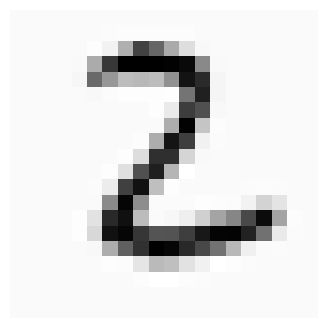

In [24]:
if indices.size > 0:
    i, indices = indices[0], indices[1:]
    utils.displayData(X[i, :], figsize=(4, 4))
    pred = predictOneVsAll(all_theta, X[i, :])
    print('One vs All Logistic Regression: {}'.format(*pred))
else:
    print('No more images to display!')